#  Study: expected sensitivity for a signal yield extraction from binned independent data

###  Code & stats by Stephen Menary, for analysis by Heather Russell

The following notebook runs through some studies aimed at evaluating the expected sensitivity for a signal fit to several binned event yields (with diagonal Poisson variance). Analysis performed is:

1. Plot expected bkg-only and sig+bkg (s+b) models
2. Use a simple $\chi^2$ test statistic (comparing the Asimov s+b dataset with the bkg-only hypothesis) to estimate the ball-park sensitivity. The $\chi^2$ will *not* be the test statistic with optimum exclusion power. It is just a useful and simple test. The most powerful test-statistic (for excluding the NULL hypothesis) will be the likelihood ratio.
3. Perform a likelihood ratio scan using the Asimov s+b dataset. Evaluating this at s=0 (the NULL) provides an estimate of the p-value we expect when using this test statistic.
4. Step 3 used Wilk's theorem. This makes the asymptotic approximation (it assumes infinite sample size). This theorem states that the likelihood-ratio (between the test-s and max-likelihood-estimate (MLE)) follows a chi2 distribution with (in our case) 1 degree of freedom. We now use toys to test this approximation at the NULL hypothesis. This demonstrates that the p-value calculated in step 3 is reliable.
5. We throw toys around the s+b hypothesis to estimate the expected sensitivity for the measured s.

Steps 3-5 seem to agree pretty well, and estimate the expected sensitivity to be around 4.6 sigma.



# Step 0: Import modules and load data

In [1]:
# ====================================
#    Import modules
# ====================================


import numpy             as     np
import matplotlib.pyplot as     plt
from   scipy             import stats
from   iminuit           import Minuit

In [2]:
# ===============================================
#    Load expected bkg and signal models
# ===============================================


exp_sig_vals   = np.array([139.926, -227.749, 211.874, -142.295])
exp_bkg_vals   = np.array([5973.95, 5807.87 , 7684.87, 5956.26 ])
exp_total_vals = exp_bkg_vals + exp_sig_vals

exp_bkg_errs   = np.sqrt(exp_bkg_vals  )
exp_total_errs = np.sqrt(exp_total_vals)

bin_indices = np.arange(len(exp_total_vals))
nDoF        = len(bin_indices)




# Step 1: plot bkg-only and s+b models

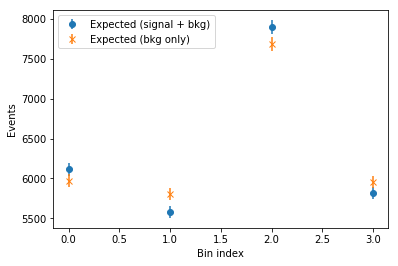

In [3]:
# ====================================
#    PLOT BKG and SIG+BKG MODELS
# ====================================


%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)

ax.errorbar(bin_indices, exp_total_vals, yerr=exp_total_errs, marker='o', linestyle='', label="Expected (signal + bkg)")
ax.errorbar(bin_indices, exp_bkg_vals  , yerr=exp_bkg_errs  , marker='x', linestyle='', label="Expected (bkg only)")

ax.set_ylabel("Events")
ax.set_xlabel("Bin index")
plt.legend()
plt.show()

# Step 2: simple estimate of sensitivity using $\chi^2$ test statistic

In [4]:
# ====================================================================================
#    Simple estimate of: sensitivity of NULL-hypothesis test if sig+bkg model true
#    -  using Asimov for s+b expectation
#    -  using chi2-vs-bkg-hypothesis as test statistic
#    -  calculating chi2 using "exp_bkg_errs" rather than "exp_total_errs", since we
#       would expect event yields to be drawn from a Poisson of mean "exp_bkg_vals[bin index]"
#       *if the bkg-only hypothesis were true*, therefore "exp_bkg_errs" is a suitable
#       Gaussian width for this hypothesis test
# ====================================================================================


def get_chi2_uncorrelated (y1, y2, ey1, ey2=None) :
    cov_diag = np.multiply(ey1, ey1)
    if ey2 is not None : cov_diag = cov_diag + np.multiply(ey2, ey2)
    res = y2 - y1
    return np.sum(np.divide(np.multiply(res, res), cov_diag))

def get_equiv_two_sided_gauss_significance (p, resolution=0.1, sigma_max = 8.) :
    x = np.linspace(sigma_max, 0, 1+int(sigma_max/resolution))
    y = 2.*(1. - stats.norm.cdf(x))
    return np.interp([p], y, x)[0]

chi2_sb_vs_bkg   = get_chi2_uncorrelated(exp_total_vals, exp_bkg_vals, exp_bkg_errs)
p_chi2_sb_vs_bkg = 1. - stats.chi2.cdf(chi2_sb_vs_bkg, nDoF)
z_chi2_sb_vs_bkg = get_equiv_two_sided_gauss_significance(p_chi2_sb_vs_bkg)
print("="*90)
print(f"    Asimov(s+b) vs. NULL hypothesis:  chi2    =  {chi2_sb_vs_bkg:.1f}  with  {nDoF} degrees of freedom")
print(f"                                      p-value =  {100.*p_chi2_sb_vs_bkg:.2f}%")
print(f"                                      2-sided Gaussian significance =  {z_chi2_sb_vs_bkg:.1f} sigma")
print("    This gives us a ball-park to cross check with later, and demonstrates that we have")
print("    sensitivity to the signal. If this wasn't the case then something like CLs would be")
print("    needed to avoid excluding models for which our experiment was not sensitive.")
print("="*90)

    Asimov(s+b) vs. NULL hypothesis:  chi2    =  21.4  with  4 degrees of freedom
                                      p-value =  0.03%
                                      2-sided Gaussian significance =  3.7 sigma
    This gives us a ball-park to cross check with later, and demonstrates that we have
    sensitivity to the signal. If this wasn't the case then something like CLs would be
    needed to avoid excluding models for which our experiment was not sensitive.


# Step 3: upgrade to the likelihood-ratio test statistic. Plot a nice likelihood ratio profile for the s+b Asimov dataset. Use Wilk's theorem to estimate the p-value with which we exclude the NULL (bkg-only) hypothesis.

In [5]:
# ====================================================================================
#    Define functions for calculating the likelihood-ratio
#    - using Gaussian PDFs to describe the observations in each bin (since we have
#      sufficient event yields to use the asymptotic approximation)
# ====================================================================================


def predicted_yields (s) :
    return exp_bkg_vals + s*exp_sig_vals

def likelihood (s, data) :
    pred = predicted_yields(s)
    return np.prod(stats.norm.pdf(data, pred, np.sqrt(pred)))

def log_likelihood (s, data) :
    return np.log(likelihood(s, data))

def TNLL (s, data) :
    return -2. * log_likelihood(s, data)

def likelihood_ratio (s1, s2, data) :
    l1 = likelihood(s1, data)
    l2 = likelihood(s2, data)
    return l1 / l2

def log_of_likelihood_ratio (s1, s2, data) :
    return np.log(likelihood_ratio(s1, s2, data))

def TNLLR (s1, s2, data) :
    return -2. * log_of_likelihood_ratio(s1, s2, data)

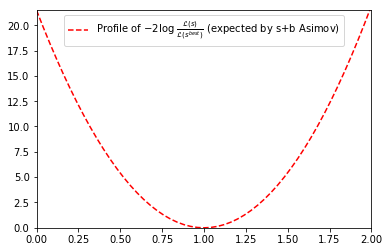

In [6]:
# ====================================================================================
#    Do a scan of the log-likelihood-ratio
#    - for Asimov data, so max-likelihood is at s=1 by definition
#    - evaluating at s=0 tells us the significance of rejecting the NULL hypothesis
#    - no fit needed as we have no nuisance params to marginalise :)
#    - BUT if we weren't using Asimov, we would fit for s^best in each dataset as this
#      is required for Wilk's theorem to be valid. This is what we will do later.
# ====================================================================================


x = np.linspace(0, 2, 51)
y = [TNLLR(xt, 1., exp_total_vals) for xt in x]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y, linestyle="--", color="red", label=r"Profile of $-2\log$ $\frac{\mathcal{L}(s)}{\mathcal{L}(s^{best})}$ (expected by s+b Asimov)")
ax.set_xlim([0, 2])
ax.set_ylim([0, y[0]])

plt.legend(loc="best")
plt.show()

In [7]:
# ====================================================================================
#    Use Wilk's theorem to estimate the p-value with which we exclude the NULL
#    hypothesis when using the likelihood-ratio as our test statistic
# ====================================================================================


chi2   = y[0]
p_chi2 = 1. - stats.chi2.cdf(chi2, 1)
z_chi2 = get_equiv_two_sided_gauss_significance(p_chi2)

print("="*110)
print("   Using Wilk's theorem [assumes the asymptotic limit of sample size], since Model(s^best) is by-definition")
print("   nested within the set of all {Model(s)}. If some s is true then we expect each measured -2LLR(s, s^best) to")
print("   be a random number drawn from a chi2 distribution with 1 degree of freedom [because 1 is the number of extra")
print("   parameters marginalised in L(s^best) rather than L(s)]. We can therefore use the LLR at s=0 to calculate the")
print("   p-value.\n")
print(f"   We then exclude the NULL hypothesis with a p-value of {100.*p_chi2:.5f}%, or significance of {z_chi2:.1f} sigma")
print("="*110)

   Using Wilk's theorem [assumes the asymptotic limit of sample size], since Model(s^best) is by-definition
   nested within the set of all {Model(s)}. If some s is true then we expect each measured -2LLR(s, s^best) to
   be a random number drawn from a chi2 distribution with 1 degree of freedom [because 1 is the number of extra
   parameters marginalised in L(s^best) rather than L(s)]. We can therefore use the LLR at s=0 to calculate the
   p-value.

   We then exclude the NULL hypothesis with a p-value of 0.00036%, or significance of 4.6 sigma


# Step 4: Throw toys around the bkg-only hypothesis. Use these to calculate the expected distribution of the likelihood-ratio. This demonstrates that Wilk's theorem is valid.

In [12]:
# ====================================================================================
#    Wilk's theorem assumed that the test-statistic follows a chi2 distribution. We
#    now prove this assumption by throwing toys around the bkg-only hypothesis and
#    overlaying it with the chi2 pdf function.
# ====================================================================================


test_val = np.array([1, 4, 9, 25])
test_err = np.sqrt(test_val)

n_toys = 10000
np.random.seed(100)
shifts = np.random.normal(size=(n_toys, len(test_val)))
toys_bkg, toys_sb = [], []
for shift in shifts :
    toys_bkg.append(exp_bkg_vals   + np.multiply(exp_bkg_errs  , shift))
    toys_sb .append(exp_total_vals + np.multiply(exp_total_errs, shift))

TNLLR_bkg_toys = []
for toy_bkg in toys_bkg :
    def eval_func(s) : return TNLL(s, toy_bkg)
    m = Minuit(eval_func, s=1, error_s=0.5, errordef=1)
    m.migrad()
    TNLLR_bkg_toys.append(TNLLR(0, m.values[0], toy_bkg))

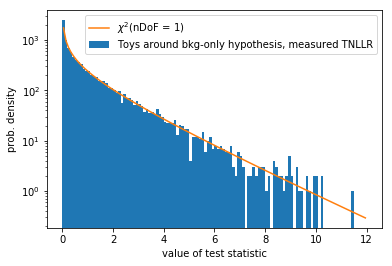

In [9]:
#  ... continued from last box, now doing the plotting...

bin_edges   = np.linspace(0, 12, 121)
bin_centres = np.linspace(0.05, 11.95, 120)
plt.hist(TNLLR_bkg_toys, bins=bin_edges, label="Toys around bkg-only hypothesis, measured TNLLR")
plt.plot(bin_centres, stats.chi2.pdf(bin_centres, 1)*0.1*n_toys, label="$\chi^2$(nDoF = 1)")
plt.legend(loc="upper right")
plt.ylabel("prob. density")
plt.xlabel("value of test statistic")
plt.gca().set_yscale("log")
plt.show()

# Step 5: explicitly estimate the expected sensitivity by throwing toys around the s+b hypothesis. In each toy we measure s. The spread of toys provides an estimate of the uncertainty on s, and the ratio is the expected sensitivity (in units of sigma)

In [10]:
# ====================================================================================
#    We can also use toys to explicitly calculate the expected sensitivity when using
#    a likelihood ratio. This will be calculated by throwing toys around the s+b
#    hypothesis and measuring s for each one. The average measured s should be 1, and
#    we then use the standard deviation of the toy measurements as the expected spread.
#    The sensitivity is estimated as mean / spread.
# ====================================================================================


measured_s_using_sb_toys = []
for toy_sb in toys_sb :
    def eval_func(s) : return TNLL(s, toy_sb)
    m = Minuit(eval_func, s=1, error_s=0.5, errordef=1)
    m.migrad()
    measured_s_using_sb_toys.append(m.values[0])

In [11]:
sb_expected_mean = np.mean(measured_s_using_sb_toys)
sb_expected_std  = np.std (measured_s_using_sb_toys)
print("="*110)
print(f"The mean measured s in s+b toys is {sb_expected_mean:.3f}  (cross check: this should be 1)")
print(f"The spread of measured s in s+b toys is {sb_expected_std:.3f}  (our expected uncertainty)")
print(f"The expected sensitivity is therefore mean / spread = {sb_expected_mean/sb_expected_std:.1f} sigma")
print("="*110)

The mean measured s in s+b toys is 1.003  (cross check: this should be 1)
The spread of measured s in s+b toys is 0.215  (our expected uncertainty)
The expected sensitivity is therefore mean / spread = 4.7 sigma
